In [1]:
! rm -rf data_prep.pyc

In [2]:
import data_prep

/home/adhamija/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import numpy as np
import cPickle
import csv
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import scipy
import multiprocessing
from multiprocessing import pool,Pool
from functools import partial

Set the GPU to Use

In [4]:
GPU_NO="0"
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = GPU_NO
#session = tf.Session(config=config)
set_session(tf.Session(config=config))

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten,Input,Conv2D,MaxPooling2D,Dropout,BatchNormalization,Activation
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras import backend as K

In [6]:
mnist=data_prep.mnist_data_prep()
letters=data_prep.letters_prep()
cifar=data_prep.cifar_prep()

In [7]:
def concatenate_training_data(obj,y,cross_entropy_probs,ring_loss=False):
    """
    Parameters:
        obj: is an object from a class in file data_prep.py
        y: are the images from the class that needs to be trained as negatives example cifar.images or letters.images
        cross_entropy_probs: Multiplier to the categorical labels
        ring_loss: Boolean value returns Y_pred_flags (Default:False)
    Returns:
        X_train_data: Numpy array containing training samples
        Y_train_data: Numpy array containing Label values
        sample_weights: 1D Numpy array containing weight of each sample
        Y_train_flags: Returned only when ring_loss=True. Numpy array containing flags indicating the sample is a known versus known unknown
    """
    X_train_data=np.concatenate((obj.X_train,y))
    Y_train_data=np.concatenate((obj.Y_train,np.ones((y.shape[0],10))*cross_entropy_probs))
    class_no=np.argmax(obj.Y_train,axis=1)
    sample_weights_knowns=np.zeros_like(class_no).astype(np.float32)
    for cls in range(obj.Y_train.shape[1]):
        sample_weights_knowns[class_no==cls]=100./len(class_no[class_no==cls])
    sample_weights=np.concatenate([sample_weights_knowns,np.ones((y.shape[0]))*(100./y.shape[0])])
    if ring_loss:
        Y_train_flags=np.zeros((X_train_data.shape[0],2))
        Y_train_flags[:obj.X_train.shape[0],0]=1
        Y_train_flags[obj.X_train.shape[0]:,1]=1
        return X_train_data,Y_train_data,sample_weights,Y_train_flags
    else:
        return X_train_data,Y_train_data,sample_weights

In [8]:
def LeNet_plus_plus(perform_L2_norm=False,activation_type='softmax',ring_approach=False):
    
    mnist_image = Input(shape=(28, 28, 1), dtype='float32', name='mnist_image')

    # 28 X 28 --> 14 X 14
    conv1_1 = Conv2D(32, (5,5), strides=1, padding="same",name='conv1_1')(mnist_image)
    conv1_2 = Conv2D(32, (5,5), strides=1, padding="same",name='conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1 = MaxPooling2D(pool_size=(2,2), strides=2,name='pool1')(conv1_2)
    # 14 X 14 --> 7 X 7
    conv2_1 = Conv2D(64, (5,5), strides=1, padding="same", name='conv2_1')(pool1)
    conv2_2 = Conv2D(64, (5,5), strides=1, padding="same", name='conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    pool2 = MaxPooling2D(pool_size=(2,2), strides=2, name='pool2')(conv2_2)
    # 7 X 7 --> 3 X 3
    conv3_1 = Conv2D(128, (5,5), strides=1, padding="same",name='conv3_1')(pool2)
    conv3_2 = Conv2D(128, (5,5), strides=1, padding="same",name='conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    pool3 = MaxPooling2D(pool_size=(2,2), strides=2, name='pool3')(conv3_2)
    flatten=Flatten(name='flatten')(pool3)
    fc = Dense(2,name='fc')(flatten)

    if perform_L2_norm:
        alpha_multipliers = Input((1,), dtype='float32', name='alphas')
        act = Activation(lambda x: alpha_multipliers*(K.l2_normalize(x,axis=1)),name='act')(fc)
        pred = Dense(10, activation=activation_type,name='pred')(act)
        model = Model(inputs=[mnist_image,alpha_multipliers], outputs=[pred])
    elif ring_approach:
        knownUnknownsFlag = Input((1,), dtype='float32', name='knownUnknownsFlag')
        pred = Dense(10, activation=activation_type,name='pred')(fc)
        model = Model(inputs=[mnist_image,unknownsMaximumMag,knownsMinimumMag], outputs=[pred,fc])
        #model = Model(inputs=[mnist_image,unknownsMaximumMag,knownsMinimumMag,knownUnknownsFlag], outputs=[pred,fc])
    else:
        pred = Dense(10, activation=activation_type,name='pred')(fc)
        model = Model(inputs=[mnist_image], outputs=[pred])
    return model

In [9]:
def extract_features(model,data):
    layer_name = 'fc'
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    print model.input_shape,len(model.input_shape)
    if len(model.input_shape)==4:
        intermediate_output = intermediate_layer_model.predict([data])
    elif len(model.input_shape)==3:
        intermediate_output = intermediate_layer_model.predict([data,np.ones(data.shape[0]),np.ones(data.shape[0])])        
    else:
        intermediate_output = intermediate_layer_model.predict([data,np.ones(data.shape[0])])
    return intermediate_output

In [10]:
def plotter_2D(pos_values,l,neg_values=None):
    plt.scatter(pos_values[:,0], pos_values[:,1], c=data_prep.colors[l.astype(np.int)],edgecolors='none',s=0.5)
    if neg_values is not None:
        plt.scatter(neg_values[:,0], neg_values[:,1],c='k',edgecolors='none',s=15,marker="*")
    plt.axis([np.min(pos_values[:,0]), np.max(pos_values[:,0]),np.min(pos_values[:,1]), np.max(pos_values[:,1])])
    plt.show()
    
    if neg_values is not None:
        pos_mag=np.sqrt(np.sum(np.square(pos_values),axis=1))
        neg_mag=np.sqrt(np.sum(np.square(neg_values),axis=1))
        pos_hist=np.histogram(pos_mag, bins=1000)#'auto')
        neg_hist=np.histogram(neg_mag, bins=1000)#'auto')
        plt.plot(pos_hist[1][1:],pos_hist[0].astype(np.float16)/max(pos_hist[0]),label='Knowns',color='g')
        plt.plot(neg_hist[1][1:],neg_hist[0].astype(np.float16)/max(neg_hist[0]),color='r',label='Unknowns')
        plt.legend()
        plt.title("Histogram")
        plt.show()

##### Raw MNIST

In [11]:
vanilla_lenet_pp=LeNet_plus_plus()
sgd = SGD(lr=0.01, decay=0.0009, momentum=0.8, nesterov=False)
vanilla_lenet_pp.compile(optimizer=sgd,loss={'pred': 'categorical_crossentropy'},metrics=['accuracy'])
info=vanilla_lenet_pp.fit(x=[mnist.X_train],y=[mnist.Y_train], batch_size=64, epochs=10,verbose=1)

Epoch 1/10
48000/48000 [==============================] - 124s 3ms/step - loss: 0.6449 - acc: 0.7954
Epoch 2/10
48000/48000 [==============================] - 12s 250us/step - loss: 0.2399 - acc: 0.9349
Epoch 3/10
48000/48000 [==============================] - 12s 250us/step - loss: 0.1527 - acc: 0.9600
Epoch 4/10
48000/48000 [==============================] - 12s 258us/step - loss: 0.1095 - acc: 0.9715
Epoch 5/10
48000/48000 [==============================] - 12s 260us/step - loss: 0.0789 - acc: 0.9805
Epoch 6/10
48000/48000 [==============================] - 13s 265us/step - loss: 0.0612 - acc: 0.9856
Epoch 7/10
48000/48000 [==============================] - 13s 267us/step - loss: 0.0481 - acc: 0.9897
Epoch 8/10
48000/48000 [==============================] - 13s 266us/step - loss: 0.0386 - acc: 0.9931
Epoch 9/10
48000/48000 [==============================] - 13s 267us/step - loss: 0.0322 - acc: 0.9947
Epoch 10/10
48000/48000 [==============================] - 13s 264us/step - loss: 0

(None, 28, 28, 1) 4


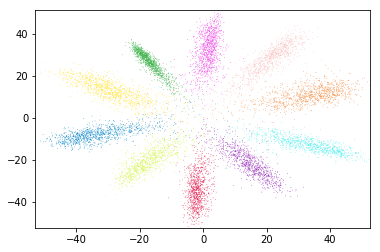

In [12]:
mnist_intermediate_output=extract_features(vanilla_lenet_pp,mnist.X_test)
plotter_2D(mnist_intermediate_output,mnist.labels_test)

Letters on Raw MNIST

(None, 28, 28, 1) 4


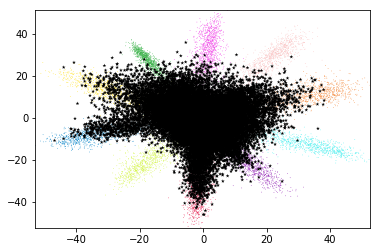

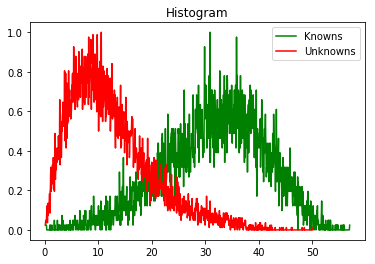

In [13]:
letters_intermediate_output=extract_features(vanilla_lenet_pp,letters.X_test)
plotter_2D(mnist_intermediate_output,mnist.labels_test,letters_intermediate_output)

CIFAR on Raw MNIST

(None, 28, 28, 1) 4


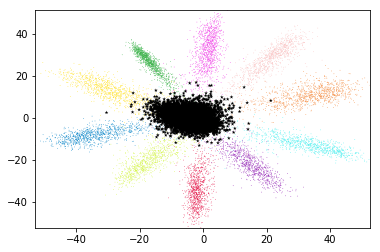

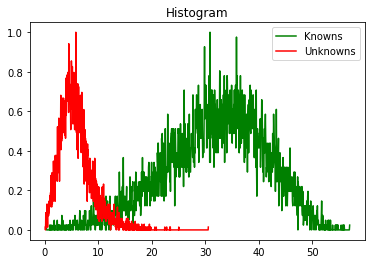

In [14]:
cifar_intermediate_output=extract_features(vanilla_lenet_pp,cifar.images)
plotter_2D(mnist_intermediate_output,mnist.labels_test,cifar_intermediate_output)

### Raw MNIST trained with LETTERS Samples as negatives (CrossEntropy Label for negatives = 0.1)

In [11]:
X_train,Y_train=concatenate_training_data(mnist,letters.X_train,0.1)
negative_training_lenet_pp=LeNet_plus_plus()
adam = Adam(lr=0.01)
negative_training_lenet_pp.compile(optimizer=adam,loss={'pred': 'categorical_crossentropy'},metrics=['accuracy'])
info=negative_training_lenet_pp.fit(x=[X_train],y=[Y_train], batch_size=64, epochs=10,verbose=1)

Epoch 1/10
147840/147840 [==============================] - 70s 473us/step - loss: 2.0043 - acc: 0.2498
Epoch 2/10
147840/147840 [==============================] - 43s 290us/step - loss: 1.7388 - acc: 0.4063
Epoch 3/10
147840/147840 [==============================] - 43s 292us/step - loss: 1.6856 - acc: 0.3934
Epoch 4/10
147840/147840 [==============================] - 43s 291us/step - loss: 1.6593 - acc: 0.3840
Epoch 5/10
147840/147840 [==============================] - 43s 292us/step - loss: 1.6412 - acc: 0.3817
Epoch 6/10
147840/147840 [==============================] - 43s 292us/step - loss: 1.6313 - acc: 0.3803
Epoch 7/10
147840/147840 [==============================] - 43s 292us/step - loss: 1.6199 - acc: 0.3781
Epoch 8/10
147840/147840 [==============================] - 43s 293us/step - loss: 1.6141 - acc: 0.3799
Epoch 9/10
147840/147840 [==============================] - 43s 292us/step - loss: 1.6094 - acc: 0.3755
Epoch 10/10
147840/147840 [==============================] - 43s

In [13]:
res=negative_training_lenet_pp.evaluate(x=[mnist.X_test], y=[mnist.Y_test])
print negative_training_lenet_pp.metrics_names
print res
res=negative_training_lenet_pp.evaluate(x=[mnist.X_train], y=[mnist.Y_train])
print "train",res

10000/10000 [==============================] - 2s 153us/step
['loss', 'acc']
[0.11746910681650043, 0.9708]
48000/48000 [==============================] - 7s 147us/step
train [0.06902320533338935, 0.9831041666666667]


(None, 28, 28, 1) 4
(None, 28, 28, 1) 4


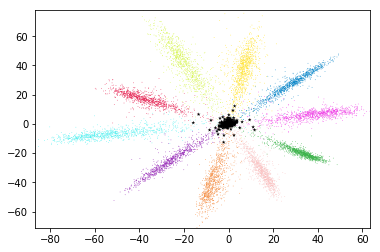

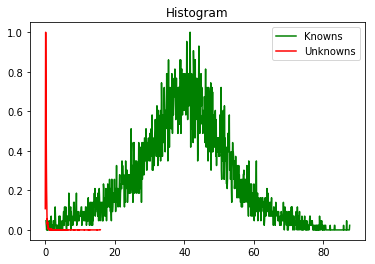

In [14]:
mnist_intermediate_output=extract_features(negative_training_lenet_pp,mnist.X_test)
letters_intermediate_output=extract_features(negative_training_lenet_pp,letters.X_test)
plotter_2D(mnist_intermediate_output,mnist.labels_test,letters_intermediate_output)

(None, 28, 28, 1) 4
(None, 28, 28, 1) 4


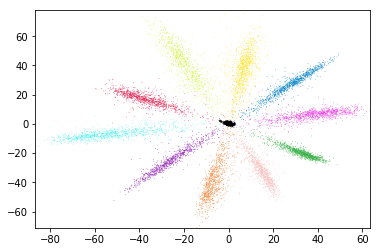

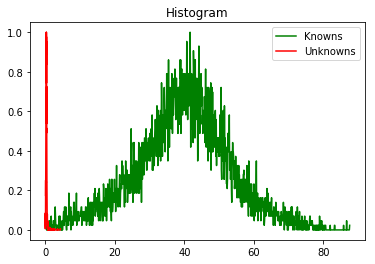

In [16]:
mnist_intermediate_output=extract_features(negative_training_lenet_pp,mnist.X_test)
cifar_intermediate_output=extract_features(negative_training_lenet_pp,cifar.images)
plotter_2D(mnist_intermediate_output,mnist.labels_test,cifar_intermediate_output)

### Training with Ring Loss

In [11]:
def ring_loss(y_true,y_pred):
    pred=K.sqrt(K.sum(K.square(y_pred),axis=1))
    error=K.mean(K.square(
        # Loss for Knowns having magnitude greater than knownsMinimumMag
        y_true[:,0]*(K.maximum(knownsMinimumMag-pred,0.))
        # Add two losses
        +
        # Loss for unKnowns having magnitude greater than unknownsMaximumMag
        y_true[:,1]*(K.maximum(pred-unknownsMaximumMag,0.))
    ))
    return error

In [12]:
X_train,Y_train,sample_weights,Y_pred_with_flags=concatenate_training_data(mnist,letters.X_train,0.1,ring_loss=True)

In [13]:
unknownsMaximumMag = Input((1,), dtype='float32', name='unknownsMaximumMag')
knownsMinimumMag = Input((1,), dtype='float32', name='knownsMinimumMag')
knownsMinimumMag_ = np.ones((X_train.shape[0]))*500
unknownsMaximumMag_ = np.ones((X_train.shape[0]))*10

In [14]:
Ring_Loss_Lenet_pp=LeNet_plus_plus(ring_approach=True)

Initially training the network with only cross entropy loss

In [15]:
adam = Adam(lr=0.01)
Ring_Loss_Lenet_pp.compile(optimizer=adam,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.},metrics=['accuracy'])
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=256, epochs=5,verbose=1,sample_weight=[sample_weights,sample_weights])

Epoch 1/5
147840/147840 [==============================] - 97s 658us/step - loss: 0.0122 - pred_loss: 0.0122 - fc_loss: 591.5575 - pred_acc: 0.2567 - fc_acc: 0.4799
Epoch 2/5
147840/147840 [==============================] - 26s 175us/step - loss: 0.0056 - pred_loss: 0.0056 - fc_loss: 568.6375 - pred_acc: 0.3128 - fc_acc: 0.4996
Epoch 3/5
147840/147840 [==============================] - 26s 178us/step - loss: 0.0045 - pred_loss: 0.0045 - fc_loss: 558.1894 - pred_acc: 0.3131 - fc_acc: 0.4101
Epoch 4/5
147840/147840 [==============================] - 26s 175us/step - loss: 0.0040 - pred_loss: 0.0040 - fc_loss: 550.3679 - pred_acc: 0.3137 - fc_acc: 0.3314
Epoch 5/5
147840/147840 [==============================] - 26s 177us/step - loss: 0.0038 - pred_loss: 0.0038 - fc_loss: 544.3983 - pred_acc: 0.3140 - fc_acc: 0.3092


In [16]:
adam = Adam(lr=0.001)
Ring_Loss_Lenet_pp.compile(optimizer=adam,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.0001},metrics=['accuracy'])
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=256, epochs=20,verbose=1,sample_weight=[sample_weights*3,sample_weights])

Epoch 1/20
147840/147840 [==============================] - 27s 180us/step - loss: 0.0555 - pred_loss: 0.0121 - fc_loss: 434.3353 - pred_acc: 0.3154 - fc_acc: 0.3390
Epoch 2/20
147840/147840 [==============================] - 26s 177us/step - loss: 0.0399 - pred_loss: 0.0155 - fc_loss: 243.8257 - pred_acc: 0.3156 - fc_acc: 0.4356
Epoch 3/20
147840/147840 [==============================] - 26s 176us/step - loss: 0.0297 - pred_loss: 0.0160 - fc_loss: 137.0034 - pred_acc: 0.3162 - fc_acc: 0.4683
Epoch 4/20
147840/147840 [==============================] - 26s 176us/step - loss: 0.0238 - pred_loss: 0.0147 - fc_loss: 91.5655 - pred_acc: 0.3167 - fc_acc: 0.4646
Epoch 5/20
147840/147840 [==============================] - 26s 175us/step - loss: 0.0202 - pred_loss: 0.0133 - fc_loss: 69.2209 - pred_acc: 0.3190 - fc_acc: 0.4561
Epoch 6/20
147840/147840 [==============================] - 26s 178us/step - loss: 0.0177 - pred_loss: 0.0122 - fc_loss: 55.2491 - pred_acc: 0.3207 - fc_acc: 0.4380
Epoch 7

In [17]:
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=256, epochs=20,verbose=1,sample_weight=[sample_weights*3,sample_weights])

Epoch 1/20
147840/147840 [==============================] - 26s 177us/step - loss: 0.0071 - pred_loss: 0.0063 - fc_loss: 8.3316 - pred_acc: 0.3386 - fc_acc: 0.3879
Epoch 2/20
147840/147840 [==============================] - 26s 174us/step - loss: 0.0069 - pred_loss: 0.0062 - fc_loss: 7.6829 - pred_acc: 0.3405 - fc_acc: 0.3971
Epoch 3/20
147840/147840 [==============================] - 26s 176us/step - loss: 0.0069 - pred_loss: 0.0061 - fc_loss: 7.1330 - pred_acc: 0.3428 - fc_acc: 0.4065
Epoch 4/20
147840/147840 [==============================] - 26s 176us/step - loss: 0.0066 - pred_loss: 0.0060 - fc_loss: 6.2422 - pred_acc: 0.3407 - fc_acc: 0.4160
Epoch 5/20
147840/147840 [==============================] - 26s 175us/step - loss: 0.0065 - pred_loss: 0.0059 - fc_loss: 5.7139 - pred_acc: 0.3455 - fc_acc: 0.4253
Epoch 6/20
147840/147840 [==============================] - 26s 177us/step - loss: 0.0064 - pred_loss: 0.0059 - fc_loss: 5.3146 - pred_acc: 0.3494 - fc_acc: 0.4372
Epoch 7/20
14784

In [19]:
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=256, epochs=20,verbose=1,sample_weight=[sample_weights*3,sample_weights])

Epoch 1/20
147840/147840 [==============================] - 25s 168us/step - loss: 0.0055 - pred_loss: 0.0054 - fc_loss: 1.7602 - pred_acc: 0.3649 - fc_acc: 0.4690
Epoch 2/20
147840/147840 [==============================] - 26s 174us/step - loss: 0.0056 - pred_loss: 0.0054 - fc_loss: 1.7773 - pred_acc: 0.3655 - fc_acc: 0.4741
Epoch 3/20
147840/147840 [==============================] - 26s 175us/step - loss: 0.0055 - pred_loss: 0.0053 - fc_loss: 1.5046 - pred_acc: 0.3681 - fc_acc: 0.4744
Epoch 4/20
147840/147840 [==============================] - 26s 175us/step - loss: 0.0053 - pred_loss: 0.0052 - fc_loss: 1.1332 - pred_acc: 0.3686 - fc_acc: 0.4699
Epoch 5/20
147840/147840 [==============================] - 26s 176us/step - loss: 0.0055 - pred_loss: 0.0053 - fc_loss: 1.4048 - pred_acc: 0.3616 - fc_acc: 0.4712
Epoch 6/20
147840/147840 [==============================] - 26s 175us/step - loss: 0.0055 - pred_loss: 0.0054 - fc_loss: 1.5466 - pred_acc: 0.3643 - fc_acc: 0.4689
Epoch 7/20
14784

In [22]:
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=256, epochs=10,verbose=1,sample_weight=[sample_weights*3,sample_weights])

Epoch 1/10
147840/147840 [==============================] - 25s 168us/step - loss: 0.0051 - pred_loss: 0.0050 - fc_loss: 0.2757 - pred_acc: 0.3758 - fc_acc: 0.4707
Epoch 2/10
147840/147840 [==============================] - 26s 173us/step - loss: 0.0055 - pred_loss: 0.0054 - fc_loss: 1.1379 - pred_acc: 0.3701 - fc_acc: 0.4754
Epoch 3/10
147840/147840 [==============================] - 26s 177us/step - loss: 0.0053 - pred_loss: 0.0052 - fc_loss: 0.9158 - pred_acc: 0.3616 - fc_acc: 0.4760
Epoch 4/10
147840/147840 [==============================] - 26s 176us/step - loss: 0.0052 - pred_loss: 0.0051 - fc_loss: 0.5138 - pred_acc: 0.3742 - fc_acc: 0.4707
Epoch 5/10
147840/147840 [==============================] - 26s 174us/step - loss: 0.0050 - pred_loss: 0.0050 - fc_loss: 0.2043 - pred_acc: 0.3802 - fc_acc: 0.4731
Epoch 6/10
147840/147840 [==============================] - 26s 176us/step - loss: 0.0050 - pred_loss: 0.0050 - fc_loss: 0.1367 - pred_acc: 0.3818 - fc_acc: 0.4705
Epoch 7/10
14784

In [23]:
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=256, epochs=10,verbose=1,sample_weight=[sample_weights*3,sample_weights])

Epoch 1/10
147840/147840 [==============================] - 25s 169us/step - loss: 0.0051 - pred_loss: 0.0051 - fc_loss: 0.4379 - pred_acc: 0.3812 - fc_acc: 0.4720
Epoch 2/10
147840/147840 [==============================] - 26s 179us/step - loss: 0.0050 - pred_loss: 0.0050 - fc_loss: 0.1394 - pred_acc: 0.3804 - fc_acc: 0.4691
Epoch 3/10
147840/147840 [==============================] - 26s 176us/step - loss: 0.0054 - pred_loss: 0.0053 - fc_loss: 0.9594 - pred_acc: 0.3659 - fc_acc: 0.4753
Epoch 4/10
147840/147840 [==============================] - 26s 176us/step - loss: 0.0052 - pred_loss: 0.0051 - fc_loss: 0.4435 - pred_acc: 0.3757 - fc_acc: 0.4735
Epoch 5/10
147840/147840 [==============================] - 26s 176us/step - loss: 0.0053 - pred_loss: 0.0052 - fc_loss: 0.7752 - pred_acc: 0.3727 - fc_acc: 0.4730
Epoch 6/10
147840/147840 [==============================] - 26s 176us/step - loss: 0.0052 - pred_loss: 0.0051 - fc_loss: 0.5213 - pred_acc: 0.3710 - fc_acc: 0.4724
Epoch 7/10
14784

In [26]:
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=256, epochs=10,verbose=1,sample_weight=[sample_weights*3,sample_weights])

Epoch 1/10
147840/147840 [==============================] - 25s 169us/step - loss: 0.0050 - pred_loss: 0.0050 - fc_loss: 0.1624 - pred_acc: 0.3776 - fc_acc: 0.4732
Epoch 2/10
147840/147840 [==============================] - 26s 174us/step - loss: 0.0050 - pred_loss: 0.0050 - fc_loss: 0.0786 - pred_acc: 0.3783 - fc_acc: 0.4710
Epoch 3/10
147840/147840 [==============================] - 26s 176us/step - loss: 0.0054 - pred_loss: 0.0053 - fc_loss: 1.0427 - pred_acc: 0.3690 - fc_acc: 0.4775
Epoch 4/10
147840/147840 [==============================] - 26s 174us/step - loss: 0.0051 - pred_loss: 0.0051 - fc_loss: 0.4735 - pred_acc: 0.3751 - fc_acc: 0.4696
Epoch 5/10
147840/147840 [==============================] - 26s 175us/step - loss: 0.0050 - pred_loss: 0.0050 - fc_loss: 0.1314 - pred_acc: 0.3811 - fc_acc: 0.4686
Epoch 6/10
147840/147840 [==============================] - 26s 173us/step - loss: 0.0050 - pred_loss: 0.0050 - fc_loss: 0.0895 - pred_acc: 0.3759 - fc_acc: 0.4702
Epoch 7/10
14784

In [27]:
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=256, epochs=5,verbose=1,sample_weight=[sample_weights*3,sample_weights])

Epoch 1/5
147840/147840 [==============================] - 26s 176us/step - loss: 0.0051 - pred_loss: 0.0051 - fc_loss: 0.3851 - pred_acc: 0.3830 - fc_acc: 0.4732
Epoch 2/5
147840/147840 [==============================] - 26s 175us/step - loss: 0.0050 - pred_loss: 0.0050 - fc_loss: 0.1100 - pred_acc: 0.3799 - fc_acc: 0.4744
Epoch 3/5
147840/147840 [==============================] - 26s 176us/step - loss: 0.0051 - pred_loss: 0.0051 - fc_loss: 0.4284 - pred_acc: 0.3732 - fc_acc: 0.4755
Epoch 4/5
147840/147840 [==============================] - 26s 176us/step - loss: 0.0052 - pred_loss: 0.0052 - fc_loss: 0.5733 - pred_acc: 0.3788 - fc_acc: 0.4779
Epoch 5/5
147840/147840 [==============================] - 26s 175us/step - loss: 0.0052 - pred_loss: 0.0051 - fc_loss: 0.5557 - pred_acc: 0.3677 - fc_acc: 0.4770


In [28]:
res=Ring_Loss_Lenet_pp.evaluate(x=[mnist.X_test,np.ones((mnist.X_test.shape[0],1)),np.ones((mnist.X_test.shape[0],1))], y=[mnist.Y_test,np.ones((mnist.Y_test.shape[0],2))])
print Ring_Loss_Lenet_pp.metrics_names
print res
res=Ring_Loss_Lenet_pp.evaluate(x=[mnist.X_train,np.ones((mnist.X_train.shape[0],1)),np.ones((mnist.X_train.shape[0],1))], y=[mnist.Y_train,np.ones((mnist.Y_train.shape[0],2))])
print "train",res

10000/10000 [==============================] - 2s 201us/step
['loss', 'pred_loss', 'fc_loss', 'pred_acc', 'fc_acc']
[122.88183049316406, 0.13609697227383113, 1227457.3662, 0.9755, 0.4375]
48000/48000 [==============================] - 10s 200us/step
train [122.16553753153482, 0.011732919221324361, 1221538.074, 0.9991666666666666, 0.4303958333333333]


[(None, 28, 28, 1), (None, 1), (None, 1)] 3
[(None, 28, 28, 1), (None, 1), (None, 1)] 3
[(None, 28, 28, 1), (None, 1), (None, 1)] 3
[(None, 28, 28, 1), (None, 1), (None, 1)] 3
[(None, 28, 28, 1), (None, 1), (None, 1)] 3


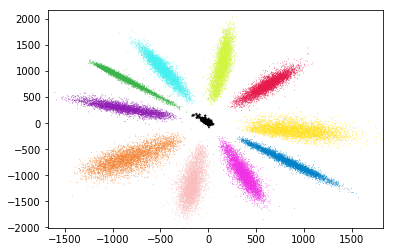

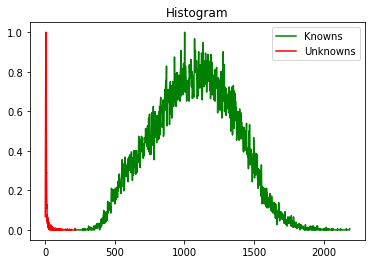

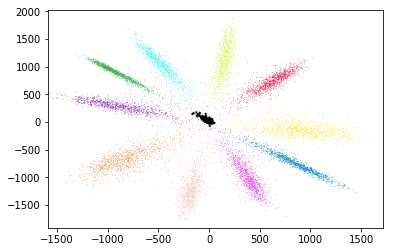

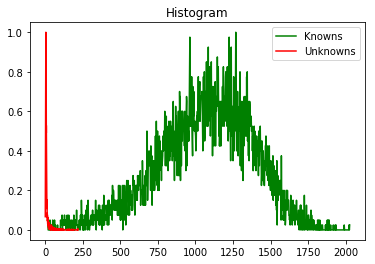

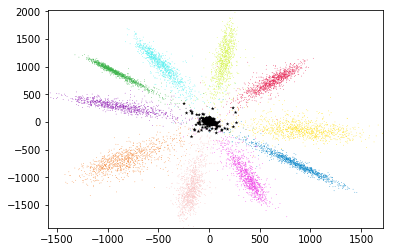

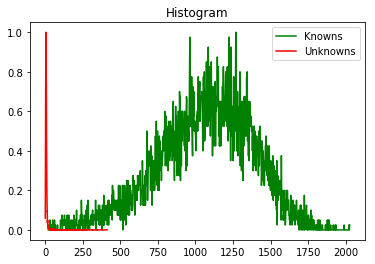

In [29]:
mnist_intermediate_output=extract_features(Ring_Loss_Lenet_pp,mnist.X_test)
cifar_intermediate_output=extract_features(Ring_Loss_Lenet_pp,cifar.images)
lettrs_intermediate_output=extract_features(Ring_Loss_Lenet_pp,letters.X_test)

train_mnist_intermediate_output=extract_features(Ring_Loss_Lenet_pp,mnist.X_train)
train_lettrs_intermediate_output=extract_features(Ring_Loss_Lenet_pp,letters.X_train)

#print mnist_intermediate_output.shape,mnist.labels_test.shape,cifar_intermediate_output.shape
#print mnist_intermediate_output,mnist.labels_test,cifar_intermediate_output
#plotter_2D(train_mnist_intermediate_output,mnist.labels_train,train_lettrs_intermediate_output)
plotter_2D(train_mnist_intermediate_output,mnist.labels_train,cifar_intermediate_output)
plotter_2D(mnist_intermediate_output,mnist.labels_test,cifar_intermediate_output)
plotter_2D(mnist_intermediate_output,mnist.labels_test,lettrs_intermediate_output)